In [499]:
%matplotlib inline

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy import stats

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')

# Fetch the latest data on the epidemic

In [500]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

data_start_index = '1/22/20'

Let's check out some of the earliest data sets.

In [501]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'Iran'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980
18,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,...,500,673,1073,1695,2277,2277,5232,6391,7798,9942
156,NaN,"Korea, South",36.0,128.0,1,1,2,2,3,4,...,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236
155,NaN,Iran,32.0,53.0,0,0,0,0,0,0,...,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991


# Modelling one country at a time

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

We want to pull out observations starting after all the metadata stuff.

For ease of modelling, we automatically drop any lead-up period in which the subset of data to be analyzed had too few infections to be modelled accurately (this period varies depending on the country you select).  This may change if the model is able to take into account underreporting due to lack of testing; for now, it just means we won't have to account for a long period with no change by inflating measurement noise and increasing parameter uncertainty.

In [502]:
# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
}

def extract_measurements(table, config):
    """Match out the row for the country, get rid of the initial metadata
    columns and drop any leading or trailing NaN values 
    """
    return table.loc[table['Country/Region'] == config['country']].loc[:, data_start_index:].dropna(axis=1).sum(axis=0)

def reached_n_infections(meas, n):
    """Return information about when the given country reached n confirmed
    cases.  
    """
    return int(max(0, meas.shape[0] - meas.loc[meas['Confirmed'] > n - 1, :].shape[0])), 'Confirmed', n

def reached_n_deaths(meas, n):
    """Return information about when the given country reached n deaths.
    """
    return int(max(0, meas.shape[0] - meas.loc[meas['Dead'] > n - 1, :].shape[0])), 'Dead', n

def truncate_initial(meas, config):
    """Truncate the measurement set before the earliest date which meets the
    infection or death threshold set above.  
    """
    confirmedt0 = reached_n_infections(meas, config['start_at_infections'])
    deatht0 = reached_n_deaths(meas, config['start_at_deaths'])
    return min(confirmedt0, deatht0, key=lambda x: x[0])

def form_table(config):
    """Form a combined table with all the statistics for a single country,
    including correct column labels for easier indexing and plotting later.
    """
    c0 = extract_measurements(confirmed, config)
    r0 = extract_measurements(recovered, config)
    d0 = extract_measurements(dead, config)
    data = pd.concat([c0, r0, d0], axis=1)
    data.columns = ['Confirmed', 'Recovered', 'Dead']
    newt0, reason, limit = truncate_initial(data, config)
    # Provide info about how the start of the data window was chosen.
    country = config['country']
    print(f'{country} reached {limit} "{reason}" on {data.index[newt0]}; dropping preceding data')
    return data.iloc[newt0:, :]

First we would like to be able to pull out the time series data from the MCMC results.

In [503]:
def get_sample_time_series(fit):
    yhat_indices = tuple([x.startswith('y_hat') for x in fit.column_names])
    yhat_samples = fit.sample[:, :, yhat_indices]
    assert(yhat_samples.shape[2] == day_count * 3)
    yhat_samples = yhat_samples.reshape((yhat_samples.shape[0] * yhat_samples.shape[1], 3, day_count))

    return yhat_samples

Next we need to be able to view the time series observations overlaid on the posterior distribution from our MCMC analysis.

In [504]:
def plot_dist_time_series_std(axis, days, obs, samples, label):
    sample_mean = np.mean(samples, axis=0)
    sample_std = np.std(samples, axis=0)

    axis.fill_between(days,
                      means - 3 * stddevs, means + 3 * stddevs,
                      label=f'{label} 3-σ', color='#f0e0e0')
    axis.fill_between(days,
                      means - stddevs, means + stddevs,
                      label=f'{label} 1-σ', color='#e0d0d0')
    axis.plot(days, means,
              label=f'{label} mean')
    axis.plot(days, obs,
              label=f'Recorded {label}',
              marker='D', linewidth=0.8)
    plt.setp(axis.get_xticklabels(), visible=False)

    axis.grid(True)
    axis.set_ylabel(f'Number of {label} cases')
    axis.legend()

def plot_dist_time_series(axis, days, obs, samples, label, subsample=10):
    for sample in samples[0:-1:subsample, :]:
        axis.plot(days,
                  sample,
                  linewidth=0.05, color='blue', alpha=0.4)
    axis.plot(days,
              samples[-1, :],
              linewidth=0.05, color='blue', alpha=0.4, 
              label=f'MCMC draws (subsampled by {subsample})')
    axis.plot(days, np.mean(samples, axis=0),
              label=f'{label} mean', color='red')
    axis.plot(days, obs,
              label=f'Recorded {label}',
              color='orange', marker='D', linewidth=0.8)

    axis.grid(True)
    axis.set_ylabel(f'Number of {label} cases')
    axis.legend()
        
def plot_posterior_time_series(samples, meas, config, plotf=plot_dist_time_series):
    days = samples.shape[2]
    
    fig = plt.figure(figsize=(15, 10))
    fig.set_tight_layout(True)
    gs = gridspec.GridSpec(3, 1)
    country = config['country']
    fig.suptitle(f'Coronavirus epidemic in {country} from {meas.index[0]} to {meas.index[-1]}')
    
    # Pull out the last axis now so that we can link x-axes (this only matters in interactive plots)
    last_axis = plt.subplot(gs[-1])
    labels = ['Confirmed', 'Recovered', 'Dead']
    for axis_idx in range(3):
        not_last = axis_idx != len(labels) - 1
        axis = plt.subplot(gs[axis_idx], sharex=last_axis) if not_last else last_axis
        plotf(axis, pd.to_datetime(meas.index),
              meas.to_numpy()[:, axis_idx],
              samples[:, axis_idx, :],
              labels[axis_idx])
        if not_last:
            plt.setp(axis.get_xticklabels(), visible=False)

    # Last axis is special for label-handling purposes
    last_axis.set_xlabel(f'Date')
    for tick in last_axis.get_xticklabels():
        tick.set_rotation(22)

    plt.tight_layout()
    plt.show()

# The actual model

Start with a configuration

In [658]:
data_config = {
    'start_at_infections':20,
    'start_at_deaths':5,
    'country':'Australia',
}

In [659]:
measurements = form_table(data_config)
day_count = measurements.shape[0]

Australia reached 20 "Confirmed" on 2/22/20; dropping preceding data


It's always a good idea to take a look at the data we plan to fit to.

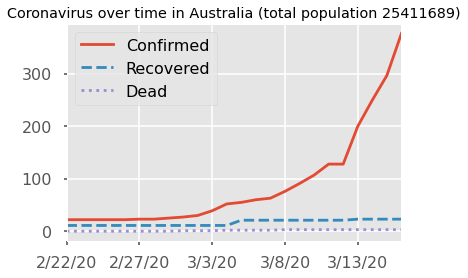

In [660]:
def display_measurements(measurements, name):
    title=f'Coronavirus over time in {name} (total population {populations[name]})'
    measurements.plot(grid=True,
                      title=title, style=['-', '--', ':'])
    
display_measurements(measurements, data_config['country'])

If you plot an early country, you can clearly see the point at which the behavior change caused an inflection point in infections.

## MCMC sampling

The first step is to arrange the data plus a bit of metadata information for the model so that we can pass it to Stan.

It's handy to be able to visualize a few distributions when assigning priors.

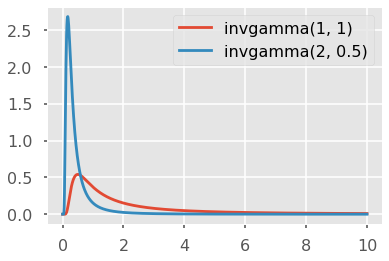

In [661]:
def plot_invgamma(x, alpha, beta, axis):
    axis.plot(x, stats.invgamma.pdf(x, alpha, scale=beta),
              label=f'invgamma({alpha}, {beta})')
    
def plot_invgammas(params):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(0, 10, 1000)
    for (alpha, beta) in params:
        plot_invgamma(x, alpha, beta, ax)
    ax.legend()

plot_invgammas([(1, 1), (2, 0.5)])

In [662]:
fit_data = {
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[country],
    'sigma_infected_prior':[2, 0.5],
    'sigma_dead_prior':[2, 0.5],
    'beta_prior':[2.2, 0.15],
    'gamma_prior':[0, 0.1],
    'zeta_prior':[0, 0.1],
    'skew_prior':[0, 2],
}

Now kick off the sampler.  Note the options commented below.

In [ ]:
model = cmdstanpy.CmdStanModel(stan_file='sird_skewed_noise.stan')

fit = model.sample(data=fit_data, output_dir='.',
                   # Use a fixed seed so that our runs are deterministic.
                   seed=2222,
                   # This computer has 8 processors, 6 chains is fine
                   chains=24,
                   # Make the sampler a bit more robust in exchange for more sampling time
                   # adapt_delta=0.95,
                   # Let the sampler explore deeper
                   # max_treedepth=12,
                   # Make sure to get enough samples to avoid any diagnostic problems
                   iter_sampling=500)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_skewed_noise
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:start chain 11
INFO:cmdstanpy:start chain 12
INFO:cmdstanpy:start chain 13
INFO:cmdstanpy:start chain 14
INFO:cmdstanpy:start chain 15
INFO:cmdstanpy:start chain 16
INFO:cmdstanpy:start chain 17
INFO:cmdstanpy:start chain 18
INFO:cmdstanpy:start chain 19
INFO:cmdstanpy:start chain 20
INFO:cmdstanpy:start chain 21
INFO:cmdstanpy:start chain 22
INFO:cmdstanpy:start chain 23
INFO:cmdstanpy:start chain 24
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 12
INFO:cmdstanpy:finish chain 24
INFO:cmdstanpy:fi

### Check the run

We'll pull up a few initial diagnostics.  If any warnings show up here, we should probably change the run parameters and resample.

In [ ]:
print(fit.diagnose())

In [ ]:
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
    'skew',
) 
fit.summary().loc[important_values, :]

In [ ]:
yhat_samples = get_sample_time_series(fit)
plot_posterior_time_series(yhat_samples, measurements, data_config)

### Error / likelihood analyses

We can look at the likelihood of the final data given the posterior distribution of parameters and the RMS error between our modelled mean value and the observations.

In [ ]:
def data_likelihood_from_fit(fit):
    results = fit.get_drawset()
    indices = tuple([x for x in fit.column_names if x.startswith('log_likelihood')])
    results.loc[:, indices].sum(axis=1)

# TODO(MP): understand this
data_likelihood_from_fit(fit)

## Extended diagnostics

We'll use arviz to do some more diagnostic plots.

In [ ]:
inferred = az.from_cmdstanpy(fit, 
                             log_likelihood='log_likelihood',
                             posterior_predictive='y_hat',
                             observed_data={'y':measurements.to_numpy()})

# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

In [ ]:
_ = az.plot_posterior(inferred, var_names=analysis_variables, kind='hist')

### Posterior correlation plots

What is going on with gamma and beta?

In [ ]:
_ = az.plot_pair(inferred, var_names=analysis_variables,
                 kind='hexbin', colorbar=True, divergences=True)

In [ ]:
_ = az.plot_trace(inferred, var_names=analysis_variables)

### Effective sample size

We don't have any low effective sample sizes.

In [ ]:
_ = az.plot_ess(inferred, var_names=analysis_variables)

### Leave-one-out analysis

Let's use the prepacked LOO analysis from Stan, provided here by arviz.

In [ ]:
loo = az.loo(inferred, pointwise=True)
_ = az.plot_khat(loo)
print(loo)

No idea what this standard error value means yet, but the diagnostics look OK (i.e. we didn't get any warnings about the pareto values getting out of the "ok" region).  Also, puzzlingly ~10 parameters?

In [ ]:
bfmi = az.bfmi(inferred)
print(bfmi < 0.5)

In [ ]:
_ = az.plot_mcse(inferred, var_names=analysis_variables)

In [ ]:
_ = az.plot_ppc(inferred, data_pairs={'y':'y_hat'})

In [ ]:
_ = az.plot_loo_pit(inferred, y='y', y_hat='y_hat')
loo_pit = az.loo_pit(inferred, y='y', y_hat='y_hat')

In [ ]:
_ = az.plot_autocorr(inferred, var_names=analysis_variables)